In [66]:
import pandas as pd
import os

# 1. Definir rutas (Best Practice: No hardcodear strings sueltos)
RAW_DATA_PATH = "data/raw/train.csv"

# 2. Verificar que el archivo existe antes de intentar leerlo
if not os.path.exists(RAW_DATA_PATH):
    print(f"❌ ERROR: No encuentro el archivo en {RAW_DATA_PATH}")
    print("¿Has movido el CSV a la carpeta correcta?")
else:
    # 3. Cargar
    df = pd.read_csv(RAW_DATA_PATH)
    print("✅ Datos cargados correctamente.")
    print(f"Dimensiones: {df.shape}")
    
    # 4. Vistazo rápido
    display(df.head())

✅ Datos cargados correctamente.
Dimensiones: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


--- INFO GENERAL ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


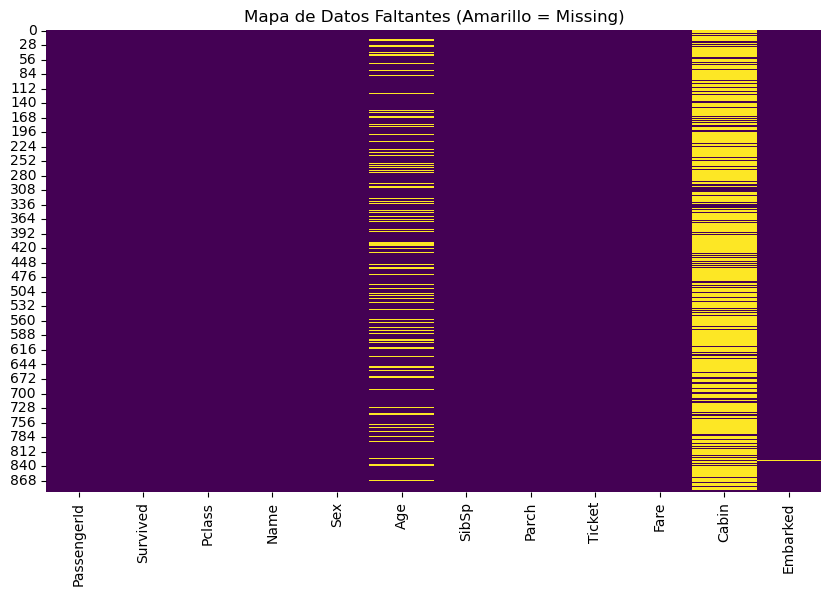

In [67]:
# 1. Información técnica (Tipos de datos y nulos brutos)
print("--- INFO GENERAL ---")
df.info()

# 2. El Mapa de Calor de la Ignorancia (Visualizar lo que falta)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Mapa de Datos Faltantes (Amarillo = Missing)")
plt.show()

In [68]:
# 1. Extraer el Título de cada nombre (Usando Regex, la magia negra del texto)
# El patrón busca: Una palabra seguida de un punto (ej: "Mr.", "Mrs.")
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# 2. Ver cuántos hay de cada uno
print(df['Title'].value_counts())

# 3. Ver la edad promedio por título
print("\n--- EDAD PROMEDIO POR TÍTULO ---")
print(df.groupby('Title')['Age'].mean())

Title
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: count, dtype: int64

--- EDAD PROMEDIO POR TÍTULO ---
Title
Capt        70.000000
Col         58.000000
Countess    33.000000
Don         40.000000
Dr          42.000000
Jonkheer    38.000000
Lady        48.000000
Major       48.500000
Master       4.574167
Miss        21.773973
Mlle        24.000000
Mme         24.000000
Mr          32.368090
Mrs         35.898148
Ms          28.000000
Rev         43.166667
Sir         49.000000
Name: Age, dtype: float64


In [69]:
# 1. Mapeo de Títulos Raros (Limpieza de ruido)
# Convertimos títulos franceses o raros a los estándar
title_mapping = {
    "Mlle": "Miss", "Ms": "Miss", "Mme": "Mrs", 
    "Lady": "Mrs", "Countess": "Mrs",
    "Capt": "Mr", "Col": "Mr", "Don": "Mr", "Dr": "Mr", 
    "Major": "Mr", "Rev": "Mr", "Sir": "Mr", "Jonkheer": "Mr",
    "Dona": "Mrs"
}

# Reemplazamos en la columna Title (si no está en el mapa, lo deja igual)
df['Title'] = df['Title'].replace(title_mapping)

# 2. IMPUTACIÓN MAESTRA (La línea de oro)
# Rellenamos los NaN de 'Age' usando la MEDIANA del grupo 'Title' al que pertenecen
df['Age'] = df['Age'].fillna(df.groupby('Title')['Age'].transform('median'))

# 3. Verificamos si queda algún hueco en Age
print("Nulos en Age tras la limpieza:", df['Age'].isnull().sum())

Nulos en Age tras la limpieza: 0


--- ESTADO DEL DATASET ---


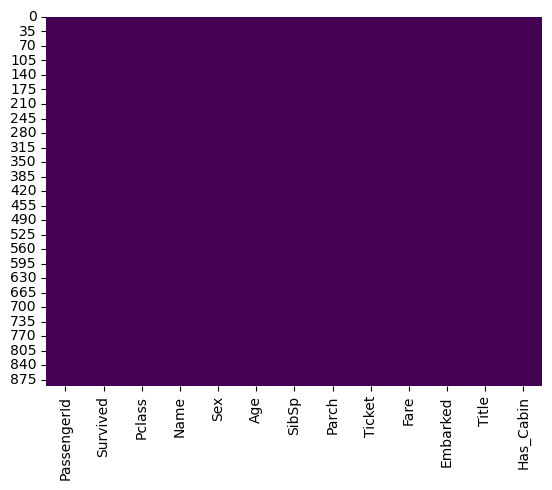

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Title          0
Has_Cabin      0
dtype: int64


In [70]:
# 1. Ingeniería sobre Cabin: Creamos 'Has_Cabin' (1 si tiene dato, 0 si es NaN)
df['Has_Cabin'] = df['Cabin'].apply(lambda x: 0 if pd.isna(x) else 1)

# 2. Borramos la columna original Cabin (ya le sacamos el jugo)
df.drop('Cabin', axis=1, inplace=True)

# 3. Rellenamos Embarked con la moda (el valor más frecuente)
mode_embarked = df['Embarked'].mode()[0]
df['Embarked'] = df['Embarked'].fillna(mode_embarked)

# 4. COMPROBACIÓN FINAL (El Check de Calidad)
print("--- ESTADO DEL DATASET ---")
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.show() # Debería salir todo morado (sin amarillo)
print(df.isnull().sum())

In [71]:
# 1. Convertir SEX a binario (Hombre=0, Mujer=1 o viceversa)
# Esto es seguro porque solo hay 2 opciones.
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

# 2. One-Hot Encoding para Embarked y Title
# drop_first=True elimina la redundancia (si no es A ni B, tiene que ser C).
# Esto evita la "Multicolinealidad" (te suena de álgebra lineal, ¿no?).
df = pd.get_dummies(df, columns=['Embarked', 'Title'], drop_first=True)

# 3. ELIMINAR BASURA RESTANTE
# Name: Ya sacamos el Title.
# Ticket: Es un código alfanumérico aleatorio (ruido).
# PassengerId: Es solo un índice.
cols_to_drop = ['Name', 'Ticket', 'PassengerId']
df.drop(cols_to_drop, axis=1, inplace=True)

# 4. VERIFICACIÓN FINAL
print("--- MATRIZ NUMÉRICA FINAL ---")
print(df.info())
display(df.head())

--- MATRIZ NUMÉRICA FINAL ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Sex         891 non-null    int64  
 3   Age         891 non-null    float64
 4   SibSp       891 non-null    int64  
 5   Parch       891 non-null    int64  
 6   Fare        891 non-null    float64
 7   Has_Cabin   891 non-null    int64  
 8   Embarked_Q  891 non-null    bool   
 9   Embarked_S  891 non-null    bool   
 10  Title_Miss  891 non-null    bool   
 11  Title_Mr    891 non-null    bool   
 12  Title_Mrs   891 non-null    bool   
dtypes: bool(5), float64(2), int64(6)
memory usage: 60.2 KB
None


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Has_Cabin,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs
0,0,3,0,22.0,1,0,7.2500,0,False,True,False,True,False
1,1,1,1,38.0,1,0,71.2833,1,False,False,False,False,True
2,1,3,1,26.0,0,0,7.9250,0,False,True,True,False,False
3,1,1,1,35.0,1,0,53.1000,1,False,True,False,False,True
4,0,3,0,35.0,0,0,8.0500,0,False,True,False,True,False


In [72]:
from sklearn.model_selection import train_test_split

# 1. Separar PREGUNTAS (X) de RESPUESTAS (y)
X = df.drop('Survived', axis=1) # Todo menos si sobrevivió
y = df['Survived']              # Solo si sobrevivió

# 2. Partir la tarta
# Test size 0.2 = Guardamos el 20% de los datos para el examen final.
# random_state = 42 asegura que si corremos esto mañana, el corte sea el mismo (reproducibilidad).
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Entrenamos con: {X_train.shape[0]} pasajeros")
print(f"Haremos el examen con: {X_test.shape[0]} pasajeros ocultos")

Entrenamos con: 712 pasajeros
Haremos el examen con: 179 pasajeros ocultos


In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 1. Instanciar (Crear el cerebro vacío)
# max_iter=1000 es para darle tiempo al algoritmo de converger si los datos son complejos.
model = LogisticRegression(max_iter=1000)

# 2. Entrenar (Estudiar)
print("🧠 Entrenando modelo...")
model.fit(X_train, y_train)

# 3. Predecir (El examen)
predictions = model.predict(X_test)

# 4. Evaluar (La nota)
accuracy = accuracy_score(y_test, predictions)
print(f"\n🎯 PRECISIÓN (Accuracy): {accuracy:.2%}")

🧠 Entrenando modelo...

🎯 PRECISIÓN (Accuracy): 82.12%


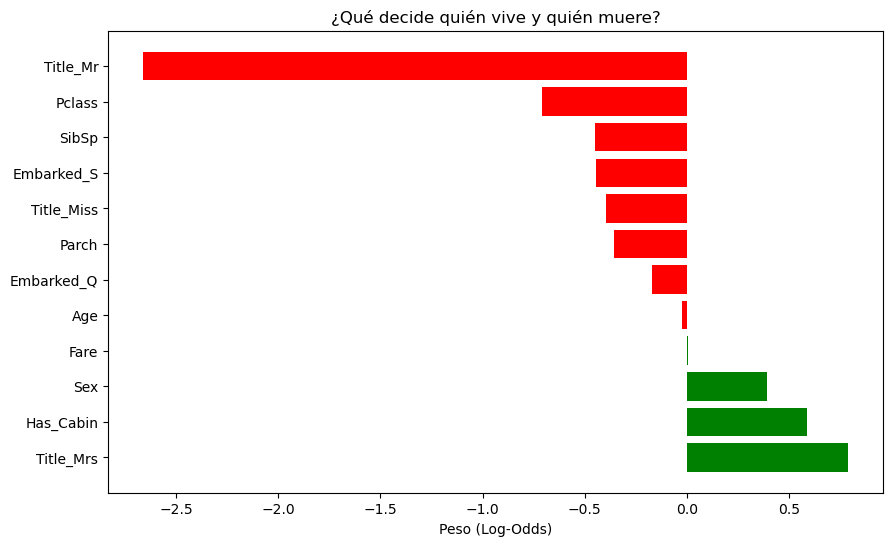

In [74]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Extraer los coeficientes (los "pesos" de la ecuación)
coefficients = model.coef_[0]
feature_names = X.columns

# 2. Crear un DataFrame para ordenarlos
feature_importance = pd.DataFrame({'Feature': feature_names, 'Weight': coefficients})
feature_importance = feature_importance.sort_values(by='Weight', ascending=False)

# 3. Visualizar
plt.figure(figsize=(10, 6))
# Colores: Verde para positivo (aumenta supervivencia), Rojo para negativo (disminuye)
colors = ['green' if x > 0 else 'red' for x in feature_importance['Weight']]
plt.barh(feature_importance['Feature'], feature_importance['Weight'], color=colors)
plt.title("¿Qué decide quién vive y quién muere?")
plt.xlabel("Peso (Log-Odds)")
plt.show()

In [75]:
import joblib
import os

# 1. Crear carpeta para guardar modelos (Organización ante todo)
model_dir = 'models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# 2. Guardar el modelo (El archivo .pkl es el binario)
joblib.dump(model, os.path.join(model_dir, 'titanic_logistic_v1.pkl'))

print("✅ Modelo guardado en /models/titanic_logistic_v1.pkl")

✅ Modelo guardado en /models/titanic_logistic_v1.pkl


In [76]:
# Para guardar, tengo que seguir: 
# 1. ADD (git add .)
# 2. COMMIT (git commit -m "Update: Restaurando notebook completo con limpieza y modelo")
# 3. PUSH (git push)

# Segunda Fase

In [77]:
# Creamos nueva columna que indique como de grande es la unidad familiar
df['FamilySize'] = df['SibSp']+df['Parch']+1
# Creamos columna para ver si esta solo
df['IsAlone'] = df["FamilySize"].apply(lambda x: 1 if x==1 else 0 )
#Comprobación
print(df[['FamilySize', 'IsAlone']].head(10))

   FamilySize  IsAlone
0           2        0
1           2        0
2           1        1
3           2        0
4           1        1
5           1        1
6           1        1
7           5        0
8           3        0
9           2        0


In [78]:
from sklearn.ensemble import RandomForestClassifier

# 1. Definir nuevas variables (X)
X = df.drop('Survived', axis=1)
y = df['Survived']

# 2. Train/Test Split (Para incluir las nuevas columnas FamilySize e IsAlone)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. CREA EL MONSTRUO
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

# 4. ENTRENA
rf_model.fit(X_train,y_train)

# 5. EVALÚA
from sklearn.metrics import accuracy_score
print("Accuracy Random Forest:", accuracy_score(y_test, rf_model.predict(X_test)))

Accuracy Random Forest: 0.8212290502793296


In [79]:
# Vemos que no hemos mejorado mucho. Para ello vamos a utilizar GridSearchCV y ver cuales nos mejoran el resultado

In [80]:
from sklearn.model_selection import GridSearchCV

# 1. Definir la "Rejilla" de opciones (El Menú)
param_grid = {
    'n_estimators': [100, 200],         # ¿100 árboles o 200?
    'max_depth': [5, 10, None],         # ¿Profundidad limitada o libre?
    'min_samples_split': [2, 5, 10],    # ¿Cuantos datos mínimos para dividir una rama?
    'min_samples_leaf': [1, 2, 4]       # ¿Cuantos datos mínimos en una hoja final?
}

# 2. Configurar el Buscador
rf_base = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf_base, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2)

# 3. ¡LUCHAR! (Entrenar todas las combinaciones)
print("⏳ Entrenando variantes... Paciencia.")
grid_search.fit(X_train, y_train)

# 4. El Ganador
print(f"🏆 Mejores Parámetros: {grid_search.best_params_}")
print(f"🚀 Mejor Accuracy (Cross-Validation): {grid_search.best_score_:.2%}")

# 5. Probar el ganador en el Test Set (La prueba de fuego)
best_rf = grid_search.best_estimator_
accuracy = accuracy_score(y_test, best_rf.predict(X_test))
print(f"🎯 Accuracy REAL en Test: {accuracy:.2%}")

⏳ Entrenando variantes... Paciencia.
Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[

In [81]:
# No hemos obtenido mejora. Vamos a probar a añadir otra columna

In [82]:
# La columna 'FarePerPerson' va a contener el cociente entre 'Fare' (precio del billete) y 'Family Size'.

df['FarePerPerson']=df['Fare']/df['FamilySize']

In [83]:
# 1. Definir nuevas variables (X)
X = df.drop('Survived', axis=1)
y = df['Survived']

# 2. Train/Test Split (Para incluir las nuevas columnas FamilySize e IsAlone)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Entrenar con los MEJORES parámetros descubiertos
# (Usamos los que ganó el GridSearch: max_depth=5, n_estimators=100)
rf_final = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_final.fit(X_train, y_train)

# 4. Resultados
acc_train = accuracy_score(y_train, rf_final.predict(X_train))
acc_test = accuracy_score(y_test, rf_final.predict(X_test))

print(f"🌲 Accuracy Training: {acc_train:.2%}")
print(f"🎯 Accuracy Test:     {acc_test:.2%}")

# 5. ¿Qué variable fue la MVP?
import pandas as pd
feature_importances = pd.Series(rf_final.feature_importances_, index=X.columns)
print("\n🔍 Top 5 Variables más importantes:")
print(feature_importances.nlargest(5))

🌲 Accuracy Training: 85.81%
🎯 Accuracy Test:     82.12%

🔍 Top 5 Variables más importantes:
Title_Mr         0.222189
Sex              0.202222
FarePerPerson    0.089037
Fare             0.081071
Pclass           0.070563
dtype: float64


In [84]:
import joblib
joblib.dump(rf_final, 'models/titanic_random_forest_v1.pkl')
print("💾 Nuevo cerebro guardado: Random Forest con Ingeniería de Características.")

💾 Nuevo cerebro guardado: Random Forest con Ingeniería de Características.


# Examen Final

In [85]:
# 1. Definir rutas (Best Practice: No hardcodear strings sueltos)
RAW_DATA_PATH_TEST = "data/raw/test.csv"

# 2. Verificar que el archivo existe antes de intentar leerlo
if not os.path.exists(RAW_DATA_PATH_TEST):
    print(f"❌ ERROR: No encuentro el archivo en {RAW_DATA_PATH_TEST}")
    print("¿Has movido el CSV a la carpeta correcta?")
else:
    # 3. Cargar
    df2 = pd.read_csv(RAW_DATA_PATH_TEST)
    df2_test = pd.read_csv(RAW_DATA_PATH_TEST)
    print("✅ Datos cargados correctamente.")
    print(f"Dimensiones: {df2.shape}")
    
    # 4. Vistazo rápido
    display(df2.head())

✅ Datos cargados correctamente.
Dimensiones: (418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


--- INFO GENERAL ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


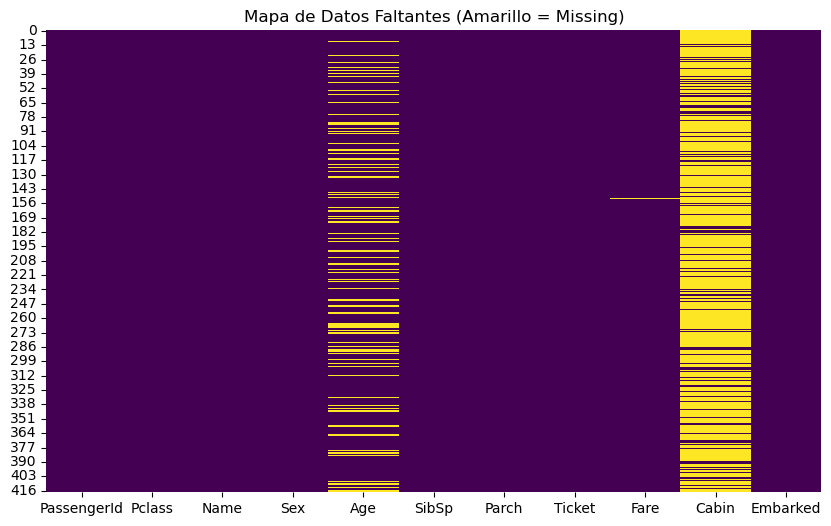

In [86]:
# 1. Información técnica (Tipos de datos y nulos brutos)
print("--- INFO GENERAL ---")
df2.info()

plt.figure(figsize=(10, 6))
sns.heatmap(df2.isnull(), cbar=False, cmap='viridis')
plt.title("Mapa de Datos Faltantes (Amarillo = Missing)")
plt.show()

In [87]:
# 1. Extraer el Título de cada nombre (Usando Regex, la magia negra del texto)
# El patrón busca: Una palabra seguida de un punto (ej: "Mr.", "Mrs.")
df2['Title'] = df2['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# 2. Ver cuántos hay de cada uno
print(df2['Title'].value_counts())

# 3. Ver la edad promedio por título
print("\n--- EDAD PROMEDIO POR TÍTULO ---")
print(df2.groupby('Title')['Age'].mean())

Title
Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Ms          1
Dr          1
Dona        1
Name: count, dtype: int64

--- EDAD PROMEDIO POR TÍTULO ---
Title
Col       50.000000
Dona      39.000000
Dr        53.000000
Master     7.406471
Miss      21.774844
Mr        32.000000
Mrs       38.903226
Ms              NaN
Rev       35.500000
Name: Age, dtype: float64


In [88]:
# 1. Mapeo de Títulos Raros (Limpieza de ruido)
# Convertimos títulos franceses o raros a los estándar
title_mapping = {
    "Ms": "Miss", "Col": "Mr", "Dr": "Mr", "Rev": "Mr", "Dona": "Mrs"
}

# Reemplazamos en la columna Title (si no está en el mapa, lo deja igual)
df2['Title'] = df2['Title'].replace(title_mapping)

# 2. IMPUTACIÓN MAESTRA (La línea de oro)
# Rellenamos los NaN de 'Age' usando la MEDIANA del grupo 'Title' al que pertenecen
df2['Age'] = df2['Age'].fillna(df2.groupby('Title')['Age'].transform('median'))

# 3. Verificamos si queda algún hueco en Age
print("Nulos en Age tras la limpieza:", df2['Age'].isnull().sum())

Nulos en Age tras la limpieza: 0


--- ESTADO DEL DATASET ---


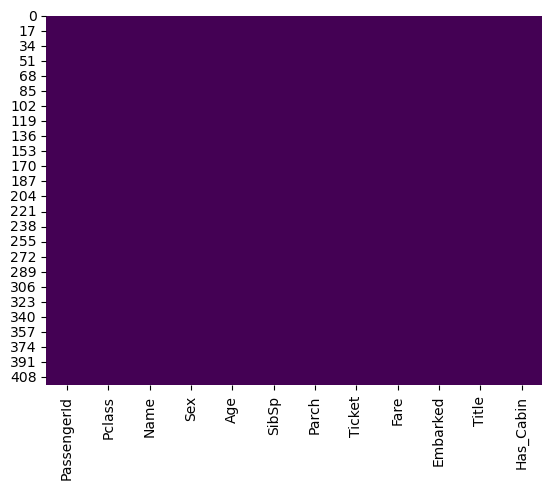

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Title          0
Has_Cabin      0
dtype: int64


In [89]:
# 1. Ingeniería sobre Cabin: Creamos 'Has_Cabin' (1 si tiene dato, 0 si es NaN)
df2['Has_Cabin'] = df2['Cabin'].apply(lambda x: 0 if pd.isna(x) else 1)

# 2. Borramos la columna original Cabin (ya le sacamos el jugo)
df2.drop('Cabin', axis=1, inplace=True)

# 3 Rellenar Fare con la mediana de su Pclass y Embarked correspondientes
df2['Fare'] = df2['Fare'].fillna(
    df2.groupby(['Pclass', 'Embarked'])['Fare'].transform('median')
)

# 4. COMPROBACIÓN FINAL (El Check de Calidad)
print("--- ESTADO DEL DATASET ---")
sns.heatmap(df2.isnull(), cbar=False, cmap='viridis')
plt.show() # Debería salir todo morado (sin amarillo)
print(df2.isnull().sum())

In [90]:
# 1. Convertir SEX a binario (Hombre=0, Mujer=1 o viceversa)
# Esto es seguro porque solo hay 2 opciones.
df2['Sex'] = df2['Sex'].map({'male': 0, 'female': 1})

# 2. One-Hot Encoding para Embarked y Title
# drop_first=True elimina la redundancia (si no es A ni B, tiene que ser C).
# Esto evita la "Multicolinealidad" (te suena de álgebra lineal, ¿no?).
df2 = pd.get_dummies(df2, columns=['Embarked', 'Title'], drop_first=True)

# 3. ELIMINAR BASURA RESTANTE
# Name: Ya sacamos el Title.
# Ticket: Es un código alfanumérico aleatorio (ruido).
# PassengerId: Es solo un índice.
cols_to_drop = ['Name', 'Ticket', 'PassengerId']
df2.drop(cols_to_drop, axis=1, inplace=True)

# 4. VERIFICACIÓN FINAL
print("--- MATRIZ NUMÉRICA FINAL ---")
print(df2.info())
display(df2.head())

--- MATRIZ NUMÉRICA FINAL ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      418 non-null    int64  
 1   Sex         418 non-null    int64  
 2   Age         418 non-null    float64
 3   SibSp       418 non-null    int64  
 4   Parch       418 non-null    int64  
 5   Fare        418 non-null    float64
 6   Has_Cabin   418 non-null    int64  
 7   Embarked_Q  418 non-null    bool   
 8   Embarked_S  418 non-null    bool   
 9   Title_Miss  418 non-null    bool   
 10  Title_Mr    418 non-null    bool   
 11  Title_Mrs   418 non-null    bool   
dtypes: bool(5), float64(2), int64(5)
memory usage: 25.0 KB
None


,Pclass,Sex,Age,SibSp,Parch,Fare,Has_Cabin,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs
0,3,0,34.5,0,0,7.8292,0,True,False,False,True,False
1,3,1,47.0,1,0,7.0000,0,False,True,False,False,True
2,2,0,62.0,0,0,9.6875,0,True,False,False,True,False
3,3,0,27.0,0,0,8.6625,0,False,True,False,True,False
4,3,1,22.0,1,1,12.2875,0,False,True,False,False,True


In [91]:
# Creamos nueva columna que indique como de grande es la unidad familiar
df2['FamilySize'] = df2['SibSp']+df2['Parch']+1
# Creamos columna para ver si esta solo
df2['IsAlone'] = df2["FamilySize"].apply(lambda x: 1 if x==1 else 0 )
#Comprobación
print(df2[['FamilySize', 'IsAlone']].head(10))

   FamilySize  IsAlone
0           1        1
1           2        0
2           1        1
3           1        1
4           3        0
5           1        1
6           1        1
7           3        0
8           1        1
9           3        0


In [92]:
# Añadimos también la columna FarePerPerson
df2['FarePerPerson']=df2['Fare']/df2['FamilySize']

In [98]:
# 1. Definir la "Rejilla" de opciones (El Menú)
param_grid = {
    'n_estimators': [100, 150, 200],         # ¿100 árboles o 200?
    'max_depth': [3, 5, 10, None],         # ¿Profundidad limitada o libre?
    'min_samples_split': [2, 5, 10],    # ¿Cuantos datos mínimos para dividir una rama?
    'min_samples_leaf': [1, 2, 4]       # ¿Cuantos datos mínimos en una hoja final?
}

# 2. Configurar el Buscador
rf_base = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf_base, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2)

# 3. ¡LUCHAR! (Entrenar todas las combinaciones)
print("⏳ Entrenando variantes... Paciencia.")
grid_search.fit(X, y)

# 4. El Ganador
print(f"🏆 Mejores Parámetros: {grid_search.best_params_}")
print(f"🚀 Mejor Accuracy (Cross-Validation): {grid_search.best_score_:.2%}")

⏳ Entrenando variantes... Paciencia.
Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.2s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.1s


In [ ]:
#No hacer caso porque hay overfitting

In [101]:
from sklearn.ensemble import RandomForestClassifier

# 1. Definir nuevas variables (X)
X = df.drop('Survived', axis=1)
y = df['Survived']

# 2. CREA EL MONSTRUO
rf_final = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1234)

# 4. ENTRENA
rf_final.fit(X,y)

predictions = rf_final.predict(df2)

output = pd.DataFrame({
    'PassengerId': df2_test['PassengerId'],
    'Survived': predictions
})

In [102]:
import os

# 1. Definir el nombre de la carpeta y el archivo
carpeta = 'resultados'
nombre_archivo = 'submission_titanic_rf.csv'

# 2. Crear la carpeta si no existe (el truco es exist_ok=True)
# Esto actúa como un "mkdir -p" en terminal. Si ya existe, no hace nada (no falla).
os.makedirs(carpeta, exist_ok=True)

# 3. Construir la ruta completa compatible con tu sistema operativo (Mac/Windows/Linux)
ruta_completa = os.path.join(carpeta, nombre_archivo)

# 4. Guardar
output.to_csv(ruta_completa, index=False)

print(f"✅ ¡Archivo generado con éxito en: {ruta_completa}!")

✅ ¡Archivo generado con éxito en: resultados/submission_titanic_rf.csv!
